# Gas Dynamics: BaseFees 

In this notebook we examine the BaseFee and method composition to determine if particular message types drove up the BaseFee. We will start our analysis with a query for second level data for August, 2021 to September 3rd, 2021 via the `derivaged_gas_ouputs` table. This analysis was first run on September 3rd, 2021.



In [2]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
from datetime import datetime
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

from Cryptoeconomics_signal_processing import time_analysis, fourier_transform, phase_shift_overlay


%matplotlib inline

import warnings
warnings.simplefilter('ignore')



In [5]:
# load connection string
CONN_STRING_PATH = '../../config/sentinel_conn_string_andrew.txt'


with open(CONN_STRING_PATH, 'r') as fid:
    conn_string = fid.read()
    
# create database connection.
connection = create_engine(conn_string, pool_recycle=3600).connect()



## Data EDA


### `derived_gas_outputs` - coped from [Sentinel's Data Dictionary](https://github.com/filecoin-project/sentinel/blob/master/docs/db.md)
Derived gas costs resulting from execution of a message in the VM.

|Name|Type|Nullable|Description|
|---|---|---|---|
|`actor_name`|`text`|NO|Human readable identifier for the type of the actor.|
|`base_fee_burn`|`text`|NO|The amount of FIL (in attoFIL) to burn as a result of the base fee. It is parent_base_fee (or gas_fee_cap if smaller) multiplied by gas_used. Note: successfull window PoSt messages are not charged this burn.|
|`cid`|`text`|NO|CID of the message.|
|`exit_code`|`bigint`|NO|The exit code that was returned as a result of executing the message. Exit code 0 indicates success. Codes 0-15 are reserved for use by the runtime. Codes 16-31 are common codes shared by different actors. Codes 32+ are actor specific.|
|`from`|`text`|NO|Address of actor that sent the message.|
|`gas_burned`|`bigint`|NO|The overestimated units of gas to burn. It is a portion of the difference between gas_limit and gas_used.|
|`gas_fee_cap`|`text`|NO|The maximum price that the message sender is willing to pay per unit of gas.|
|`gas_limit`|`bigint`|YES|A hard limit on the amount of gas (i.e., number of units of gas) that a message’s execution should be allowed to consume on chain. It is measured in units of gas.|
|`gas_premium`|`text`|NO|The price per unit of gas (measured in attoFIL/gas) that the message sender is willing to pay (on top of the BaseFee) to "tip" the miner that will include this message in a block.|
|`gas_refund`|`bigint`|NO|The overestimated units of gas to refund. It is a portion of the difference between gas_limit and gas_used.|
|`gas_used`|`bigint`|NO|A measure of the amount of resources (or units of gas) consumed, in order to execute a message.|
|`height`|`bigint`|NO|Epoch this message was executed at.|
|`method`|`bigint`|YES|The method number to invoke. Only unique to the actor the method is being invoked on. A method number of 0 is a plain token transfer - no method exectution.|
|`miner_penalty`|`text`|NO|Any penalty fees (in attoFIL) the miner incured while executing the message.|
|`miner_tip`|`text`|NO|The amount of FIL (in attoFIL) the miner receives for executing the message. Typically it is gas_premium * gas_limit but may be lower if the total fees exceed the gas_fee_cap.|
|`nonce`|`bigint`|YES|The message nonce, which protects against duplicate messages and multiple messages with the same values.|
|`over_estimation_burn`|`text`|NO|The fee to pay (in attoFIL) for overestimating the gas used to execute a message. The overestimated gas to burn (gas_burned) is a portion of the difference between gas_limit and gas_used. The over_estimation_burn value is gas_burned * parent_base_fee.|
|`parent_base_fee`|`text`|NO|The set price per unit of gas (measured in attoFIL/gas unit) to be burned (sent to an unrecoverable address) for every message execution.|
|`refund`|`text`|NO|The amount of FIL (in attoFIL) to refund to the message sender after base fee, miner tip and overestimation amounts have been deducted.|
|`size_bytes`|`bigint`|YES|Size in bytes of the serialized message.|
|`state_root`|`text`|NO|CID of the parent state root.|
|`to`|`text`|NO|Address of actor that received the message.|
|`value`|`text`|NO|The FIL value transferred (attoFIL) to the message receiver.|





In [15]:
QUERY = """
SELECT 
date_trunc('second', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
AVG(CAST(gas_fee_cap AS FLOAT)) AS mean_gas_fee_cap,
AVG(CAST(gas_premium AS FLOAT))  as mean_gas_premium,
AVG(CAST(gas_limit AS FLOAT))  as mean_gas_limit,
AVG(CAST(gas_used AS FLOAT))  as mean_gas_used,
AVG(CAST(parent_base_fee AS FLOAT))  as mean_parent_base_fee,
AVG(CAST(base_fee_burn AS FLOAT))  as mean_base_fee_burn,
AVG(CAST(over_estimation_burn AS FLOAT))  as mean_over_estimation_burn,
AVG(CAST(gas_refund AS FLOAT))  as mean_gas_refund,
AVG(CAST(gas_burned AS FLOAT))  as mean_gas_burned
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-08-01' AND '2021-09-03'
GROUP BY
timestamp
"""
derived_gas_outputs_seconds = (pd.read_sql(QUERY, connection))
derived_gas_outputs_seconds

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
0,2021-08-01 00:00:00+00:00,2.479436e+09,104809.452703,4.510736e+07,3.725947e+07,185566616.0,6.914113e+15,2.047379e+14,6.744582e+06,1.103312e+06
1,2021-08-01 00:01:00+00:00,2.715663e+09,118502.672646,4.614822e+07,3.757843e+07,187453084.0,7.044193e+15,2.721401e+14,7.118012e+06,1.451777e+06
2,2021-08-01 00:01:30+00:00,2.365101e+09,100697.363924,4.308007e+07,3.505964e+07,198558366.0,6.961384e+15,2.625591e+14,6.698103e+06,1.322327e+06
3,2021-08-01 00:02:00+00:00,2.732835e+09,109170.960000,4.471044e+07,3.600300e+07,200822074.0,7.230197e+15,4.032334e+14,6.699530e+06,2.007914e+06
4,2021-08-01 00:02:30+00:00,2.503057e+09,106448.443005,4.486660e+07,3.585641e+07,195668150.0,7.015957e+15,4.049686e+14,6.940522e+06,2.069670e+06
...,...,...,...,...,...,...,...,...,...,...
94362,2021-09-02 23:58:00+00:00,7.223611e+09,102689.290393,3.730181e+07,2.993437e+07,574051675.0,1.718387e+16,9.140324e+14,5.775194e+06,1.592248e+06
94363,2021-09-02 23:58:30+00:00,6.893610e+09,107602.595903,4.232069e+07,3.366469e+07,584454410.0,1.967548e+16,1.241914e+15,6.531085e+06,2.124911e+06
94364,2021-09-02 23:59:00+00:00,6.769215e+09,109280.245238,4.316105e+07,3.419608e+07,595248035.0,2.035515e+16,1.390996e+15,6.628139e+06,2.336834e+06
94365,2021-09-02 23:59:30+00:00,8.198577e+09,392252.110701,3.689569e+07,2.963142e+07,610762385.0,1.809776e+16,9.077653e+14,5.777987e+06,1.486282e+06


In [7]:
derived_gas_outputs_seconds.describe()

,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
count,8.865800e+04,8.865800e+04,8.865800e+04,8.865800e+04,8.865800e+04,8.865800e+04,8.865800e+04,8.865800e+04,8.865800e+04
mean,2.850266e+09,3.660835e+05,4.682800e+07,3.820216e+07,1.958103e+08,7.384229e+15,3.505092e+14,6.820152e+06,1.805683e+06
std,1.253477e+09,1.409795e+07,5.452305e+06,4.425344e+06,1.127684e+08,3.978709e+15,2.922738e+14,6.813614e+05,9.253933e+05
min,6.114552e+08,2.356565e+04,1.293338e+07,9.746298e+06,7.005124e+07,1.127782e+15,6.716768e+13,1.862822e+06,6.252377e+05
25%,2.262979e+09,1.043112e+05,4.299586e+07,3.507294e+07,1.422740e+08,5.425020e+15,2.033861e+14,6.368307e+06,1.225061e+06
50%,2.618342e+09,1.071235e+05,4.607183e+07,3.758776e+07,1.659049e+08,6.354072e+15,2.777614e+14,6.751616e+06,1.535066e+06
75%,3.099749e+09,1.116315e+05,4.990850e+07,4.075677e+07,2.064711e+08,7.831710e+15,4.003904e+14,7.189323e+06,2.101473e+06
max,2.022433e+11,4.006193e+09,1.361815e+08,1.083815e+08,1.851613e+09,6.658142e+16,2.935902e+16,2.234506e+07,5.406530e+07


<AxesSubplot:xlabel='timestamp'>

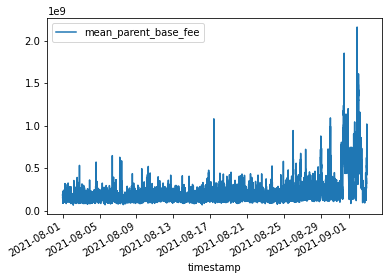

In [16]:
derived_gas_outputs_seconds.plot(x='timestamp',y='mean_parent_base_fee')

<AxesSubplot:xlabel='timestamp'>

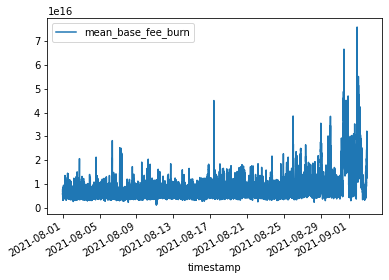

In [17]:
derived_gas_outputs_seconds.plot(x='timestamp',y='mean_base_fee_burn')

From the above plots of base fee, we can see a dramatic increase during the first couple days of September. Of particular interest is *which* methods drove up the base fee. Specifically, the question has been asked if PublishStorageDeals or storagemarket/4 is responsible for much of the increase. We will uncover below. To do so we will first determine the method types used during the time period specified.

In [25]:
# # message level data
QUERY = """
SELECT DISTINCT
d.actor_name,
d.method
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-08-01' AND '2021-09-03'
GROUP BY
d.actor_name,
d.method
"""
derived_gas_outputs_message_level_actors = (pd.read_sql(QUERY, connection))



In [26]:
derived_gas_outputs_message_level_actors

,actor_name,method
0,fil/5/account,0
1,fil/5/account,2
2,fil/5/init,2
3,fil/5/multisig,0
4,fil/5/multisig,2
5,fil/5/multisig,3
6,fil/5/multisig,4
7,fil/5/paymentchannel,0
8,fil/5/storagemarket,2
9,fil/5/storagemarket,3


In order to understand what the specific methods signify, we have begun creating a mapping table from Filecoin's system code:

https://docs.google.com/spreadsheets/d/13sfwHtT1YO94a37JmA956a1HcFJ_FtMQegu1oTE3WaQ/edit#gid=0

Method types are not unique across actor types. Without having this formalized and connected to git commits, these values may be inaccurate.

In [20]:
# V1 - 6/27/2021
mapping = pd.read_csv('derived_gas_outputs_actor_name_methods_mapping - Mapping.csv')

Below we will query all Storage Market Actor transactions for August, early September 2021

In [57]:
# # message level data
QUERY = """
SELECT 
to_timestamp(height_to_unix(d.height)) as timestamp,
d.base_fee_burn,
d.exit_code,
d.gas_burned,
d.gas_fee_cap,
d.gas_limit,
d.gas_premium,
d.gas_refund,
d.gas_used,
d.height,
d.method,
d.miner_penalty,
d.miner_tip,
d.nonce,
d.over_estimation_burn,
d.parent_base_fee,
d.refund
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-08-01' AND '2021-09-03'
AND d.actor_name = 'fil/5/storagemarket'
"""

derived_gas_outputs_message_level_storage_market = (pd.read_sql(QUERY, connection))


# add column and subset dataframe
derived_gas_outputs_message_level_storage_market['Actor_name'] = 'Market'
#.hist(column='gas_used', by='method', grid=True, legend=True,figsize=(15, 10))

In [58]:
derived_gas_outputs_message_level_storage_market.groupby('method').sum('base_fee_burn')

,base_fee_burn,exit_code,gas_burned,gas_fee_cap,gas_limit,gas_premium,gas_refund,gas_used,height,miner_penalty,miner_tip,nonce,over_estimation_burn,parent_base_fee,refund
method,,,,,,,,,,,,,,,
2,7.597937e+19,20,12668951600,7.205691e+13,452362446985,1.017693e+10,75736537288,363956958097,34264553351,1.288089e+16,5.310752e+16,2365035813,2.645286e+18,6.935852e+12,9.014251e+20
3,6.724315e+16,0,13147865,6.129601e+10,438903813,3.100841e+06,74591282,351164666,31989315,0.000000e+00,4.390088e+13,205878,2.517286e+15,5.948665e+09,7.965713e+17
4,9.124572e+20,463,173000619020,4.868047e+13,5377754550063,7.442258e+09,903329939943,4301423991100,28144111731,8.050533e+17,9.273741e+17,2157848437,3.663992e+19,5.796717e+12,8.869075e+21


In [59]:
method_analysis_storage.Method.unique()

array(['PublishStorageDeals', 'AddBalance', 'WithdrawBalance'],
      dtype=object)

Three methods existed within the storage market. We will examine PublishStorageDeals specifically

<AxesSubplot:title={'center':'PublishStorageDeals'}, xlabel='timestamp'>

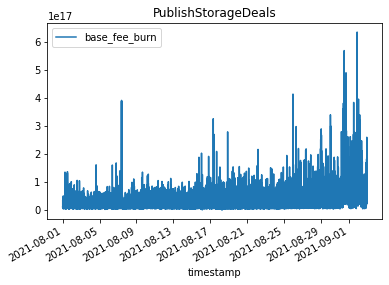

In [62]:
method_analysis_storage = pd.merge(derived_gas_outputs_message_level_storage_market, mapping,  how='left', left_on=['Actor_name','method'], 
                           right_on = ['Actor_name','Method number'])

PublishStorageDeals = method_analysis_storage.query('Method == "PublishStorageDeals"')
PublishStorageDeals.plot(x='timestamp',y='base_fee_burn',title='PublishStorageDeals only')

We can see that PublishStorageDeals did exhibit the increase in base fees, but doesn't appear that it was driving the increase by itsef. We will examine all storage methods next.

<AxesSubplot:title={'center':'All storagemarket methods'}, xlabel='timestamp'>

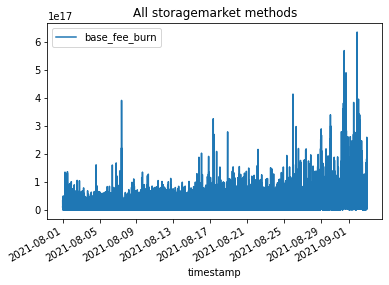

In [67]:
method_analysis_storage.plot(x='timestamp',y='base_fee_burn', title='All storagemarket methods')

No additional information could be obtained from the all storage methods plot. We will now obtain the second aggregated data for the storagemarket, so we can compare to set of all basefee data.

In [116]:
# method_analysis_storage['Method number'] = method_analysis_storage['Method number'].astype(int)
# method_analysis_subset = method_analysis_storage[['base_fee_burn','Method']] 
# method_analysis_subset.hist(by='Method',bins=30, figsize=(15, 15))

In [100]:
QUERY = """
SELECT 
date_trunc('second', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
AVG(CAST(gas_fee_cap AS FLOAT)) AS mean_gas_fee_cap,
AVG(CAST(gas_premium AS FLOAT))  as mean_gas_premium,
AVG(CAST(gas_limit AS FLOAT))  as mean_gas_limit,
AVG(CAST(gas_used AS FLOAT))  as mean_gas_used,
AVG(CAST(parent_base_fee AS FLOAT))  as mean_parent_base_fee,
AVG(CAST(base_fee_burn AS FLOAT))  as mean_base_fee_burn_storage,
AVG(CAST(over_estimation_burn AS FLOAT))  as mean_over_estimation_burn,
AVG(CAST(gas_refund AS FLOAT))  as mean_gas_refund,
AVG(CAST(gas_burned AS FLOAT))  as mean_gas_burned
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-08-01' AND '2021-09-03' and d.actor_name = 'fil/5/storagemarket'
GROUP BY
timestamp
"""
derived_gas_outputs_seconds_storage = (pd.read_sql(QUERY, connection))
derived_gas_outputs_seconds_storage

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn_storage,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
0,2021-08-01 00:02:30+00:00,6.492666e+08,100448.0,77009966.0,61669073.0,195668150.0,1.206667e+16,4.465409e+14,13058759.0,2282134.0
1,2021-08-01 00:04:00+00:00,5.813029e+08,99206.0,86013677.0,68872042.0,177793449.0,1.224500e+16,4.537708e+14,14589399.0,2552236.0
2,2021-08-01 00:06:30+00:00,3.244322e+08,99735.0,93403266.0,74785013.0,149152029.0,1.115434e+16,4.136462e+14,15844934.0,2773319.0
3,2021-08-01 00:07:30+00:00,6.238724e+08,99488.0,80144591.0,64176773.0,164539920.0,1.055964e+16,3.909747e+14,13591649.0,2376169.0
4,2021-08-01 00:08:30+00:00,1.734839e+09,99746.0,302263805.0,241872144.0,147186224.0,3.560025e+16,1.330516e+15,51351982.0,9039679.0
...,...,...,...,...,...,...,...,...,...,...
42526,2021-09-02 23:54:30+00:00,5.627686e+09,99908.0,13771671.0,11079737.0,543425775.0,6.021015e+15,2.091314e+14,2307095.0,384839.0
42527,2021-09-02 23:55:00+00:00,5.906708e+09,99945.5,13806769.0,11107815.5,536542157.0,5.959811e+15,2.070465e+14,2313063.0,385890.5
42528,2021-09-02 23:56:30+00:00,7.696031e+08,99068.0,64968557.0,52035946.0,581612960.0,3.026478e+16,1.117226e+15,11011701.0,1920910.0
42529,2021-09-02 23:58:00+00:00,9.107769e+08,100101.0,329389116.0,263573693.0,574051675.0,1.513049e+17,5.656037e+15,55962587.0,9852836.0


Below we plot the second aggregated data, from all actors and methods, as well as for the storage actor only.

<AxesSubplot:title={'center':'All actors and methods'}, xlabel='timestamp'>

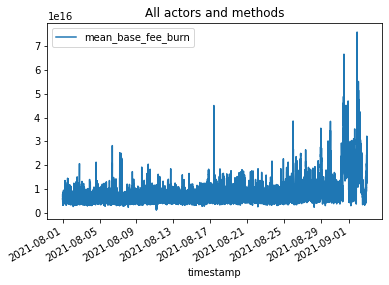

In [114]:
derived_gas_outputs_seconds.plot(x='timestamp',y='mean_base_fee_burn', title='All actors and methods')

<AxesSubplot:title={'center':'Storage Actor'}, xlabel='timestamp'>

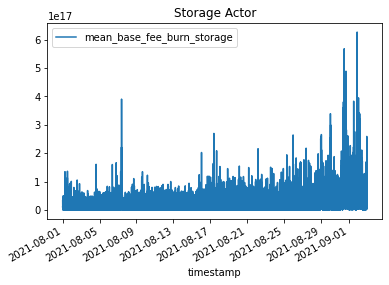

In [115]:
derived_gas_outputs_seconds_storage.plot(x='timestamp',y='mean_base_fee_burn_storage',title='Storage Actor')

The plots appear very similar, but at different orders of magnitude (see le17 and l16 on the plots). This tells us that the storage actor alone is not the only driver of the base fee increase. We will now obtain all actor, methods, and mean base fee per day to ascertain if there are any specific actors/methods driving the increase or if it spread across the network.

In [190]:
QUERY = """
SELECT 
date_trunc('second', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
AVG(CAST(gas_fee_cap AS FLOAT)) AS mean_gas_fee_cap,
AVG(CAST(gas_premium AS FLOAT))  as mean_gas_premium,
AVG(CAST(gas_limit AS FLOAT))  as mean_gas_limit,
AVG(CAST(gas_used AS FLOAT))  as mean_gas_used,
AVG(CAST(parent_base_fee AS FLOAT))  as mean_parent_base_fee,
AVG(CAST(base_fee_burn AS FLOAT))  as mean_base_fee_burn,
AVG(CAST(over_estimation_burn AS FLOAT))  as mean_over_estimation_burn,
AVG(CAST(gas_refund AS FLOAT))  as mean_gas_refund,
AVG(CAST(gas_burned AS FLOAT))  as mean_gas_burned
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-08-01' AND '2021-09-03' and d.actor_name = 'fil/5/storageminer'
GROUP BY
timestamp
"""
derived_gas_outputs_seconds_miner = (pd.read_sql(QUERY, connection))
derived_gas_outputs_seconds_miner

,timestamp,mean_gas_fee_cap,mean_gas_premium,mean_gas_limit,mean_gas_used,mean_parent_base_fee,mean_base_fee_burn,mean_over_estimation_burn,mean_gas_refund,mean_gas_burned
0,2021-08-01 00:00:00+00:00,2486191339.69388,104806.39796,45410179.64456,37509596.77041,185566616.00000,6960528940209176.00000,206113885720265.06250,6789855.68537,1110727.18878
1,2021-08-01 00:01:00+00:00,2769950903.37740,119721.29087,49435859.97837,40256034.88221,187453084.00000,7546117888282128.00000,291546675101607.75000,7624520.32933,1555304.76683
2,2021-08-01 00:01:30+00:00,2383409534.33826,100723.37603,44682170.93268,36366899.53530,198558366.00000,7220952148216073.00000,271542666409385.93750,6947700.38095,1367571.01642
3,2021-08-01 00:02:00+00:00,2732834921.16870,109170.96000,44710444.63826,36003001.48174,200822074.00000,7230197427787920.00000,403233354704994.37500,6699529.65043,2007913.50609
4,2021-08-01 00:02:30+00:00,2513153463.45431,106180.86945,45002301.33943,35973683.33159,195668150.00000,7038904066178575.00000,404661127314814.50000,6960518.89556,2068099.11227
...,...,...,...,...,...,...,...,...,...,...
94362,2021-09-02 23:58:00+00:00,5936214839.29250,100400.64250,41466529.48750,33545569.68500,574051675.00000,19256890466503480.00000,831676973761468.37500,6472175.64250,1448784.16000
94363,2021-09-02 23:58:30+00:00,5698493822.04202,108067.35714,47098353.14916,37693978.34874,584454410.00000,22030411876365300.00000,1216094949385841.00000,7323639.45378,2080735.34664
94364,2021-09-02 23:59:00+00:00,5793481036.54450,109684.17801,47157126.23037,37548680.51047,595248035.00000,22350778290700804.00000,1381548450020456.25000,7287483.08115,2320962.63874
94365,2021-09-02 23:59:30+00:00,6936580523.74262,433975.61603,41758365.43460,33811544.72152,610762385.00000,20650819694649096.00000,818374987256560.62500,6606897.02532,1339923.68776


<AxesSubplot:title={'center':'Storage Miner'}, xlabel='timestamp'>

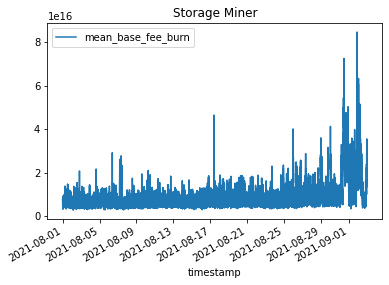

In [191]:
derived_gas_outputs_seconds_miner.plot(x='timestamp',y='mean_base_fee_burn',title='Storage Miner')

In [158]:
# # message level aggregated by method and actor per day.
QUERY = """
SELECT 
date_trunc('day', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
d.actor_name,
d.method,
AVG(CAST(d.base_fee_burn AS FLOAT)) as mean_base_fee_burn
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) BETWEEN '2021-08-01' AND '2021-09-03'
GROUP BY
d.actor_name,
d.method,
timestamp
"""
derived_gas_outputs_actor_method_aggregate = (pd.read_sql(QUERY, connection))




In [123]:
derived_gas_outputs_actor_method_aggregate

,timestamp,actor_name,method,mean_base_fee_burn
0,2021-08-01 00:00:00+00:00,fil/5/account,0,99266952194026.28125
1,2021-08-02 00:00:00+00:00,fil/5/account,0,96512057291424.76562
2,2021-08-03 00:00:00+00:00,fil/5/account,0,98464270125166.17188
3,2021-08-04 00:00:00+00:00,fil/5/account,0,100475439185148.42188
4,2021-08-05 00:00:00+00:00,fil/5/account,0,99074973522114.35938
...,...,...,...,...
907,2021-08-30 00:00:00+00:00,<unknown>,0,857236070501706.87500
908,2021-08-31 00:00:00+00:00,<unknown>,0,1051668077636680.12500
909,2021-09-01 00:00:00+00:00,<unknown>,0,521030034984201.81250
910,2021-09-02 00:00:00+00:00,<unknown>,0,858390917589387.50000


In [126]:
mapping.fillna(0,inplace=True)

In [198]:
mapping['Method number'] = mapping['Method number'].astype(int)

In [131]:
# the method table will need to be updated to fil/5 for all actors before we can use it for mapping
method_analysis = pd.merge(derived_gas_outputs_actor_method_aggregate, mapping,  how='left', left_on=['actor_name','method'], 
                           right_on = ['Actor_name','Method number'])



In [162]:
derived_gas_outputs_actor_method_aggregate = derived_gas_outputs_actor_method_aggregate[derived_gas_outputs_actor_method_aggregate['actor_name']!='<unknown>']

In [163]:
derived_gas_outputs_actor_method_aggregate.groupby(['timestamp','actor_name']).mean('mean_base_fee_burn')

method  \
timestamp                 actor_name                        
2021-08-01 00:00:00+00:00 fil/5/account           0.00000   
                          fil/5/init              2.00000   
                          fil/5/multisig          1.66667   
                          fil/5/paymentchannel    0.00000   
                          fil/5/storagemarket     3.00000   
...                                                   ...   
2021-09-02 00:00:00+00:00 fil/5/storageminer     14.16667   
                          fil/5/storagepower      2.00000   
                          fil/5/verifiedregistry  4.00000   
2021-09-03 00:00:00+00:00 fil/5/account           0.00000   
                          fil/5/storageminer     13.33333   

                                                      mean_base_fee_burn  
timestamp                 actor_name                                      
2021-08-01 00:00:00+00:00 fil/5/account             99266952194026.28125  
                          fil/5/init              2286349349689732.00000  
                          fil/5/multisig           711785421576711.37500  
                          fil/5/paymentchannel      95299357859038.67188  
                          fil/5/storagemarket    12934563058387446.00000  
...                                                                  ...  
2021-09-02 00:00:00+00:00 fil/5/storageminer     19364689526745968.00000  
                          fil/5/storagepower      9104543646627666.00000  
                          fil/5/verifiedregistry  4292710612423759.00000  
2021-09-03 00:00:00+00:00 fil/5/account            310806625977535.12500  
                          fil/5/storageminer     40675143506335656.00000  

[249 rows x 2 columns]

# TODO: 

* Check August 1 distribution of actors and mean base fee vs September 2.

In [192]:
# # message level aggregated by method and actor per day.
QUERY = """
SELECT 
date_trunc('day', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
d.actor_name,
d.method,
AVG(CAST(d.base_fee_burn AS FLOAT))  as mean_base_fee_burn
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) = '2021-08-02' 
GROUP BY
d.actor_name,
d.method,
timestamp
"""
derived_gas_outputs_actor_method_aggregate_August = (pd.read_sql(QUERY, connection))



# # message level aggregated by method and actor per day.
QUERY = """
SELECT 
date_trunc('day', 
to_timestamp(height_to_unix(d.height))) AS timestamp,
d.actor_name,
d.method,
AVG(CAST(d.base_fee_burn AS FLOAT))  as mean_base_fee_burn
FROM derived_gas_outputs d
WHERE
to_timestamp(height_to_unix(d.height)) = '2021-09-02' 
GROUP BY
d.actor_name,
d.method,
timestamp
"""
derived_gas_outputs_actor_method_aggregate_september = (pd.read_sql(QUERY, connection))






In [193]:
derived_gas_outputs_actor_method_aggregate_August

,timestamp,actor_name,method,mean_base_fee_burn
0,2021-08-02 00:00:00+00:00,fil/5/account,0,89119099970732.00000
1,2021-08-02 00:00:00+00:00,fil/5/storagemarket,2,1990601302165038.00000
2,2021-08-02 00:00:00+00:00,fil/5/storageminer,5,3084924211855015.00000
3,2021-08-02 00:00:00+00:00,fil/5/storageminer,6,2842718744289038.50000
4,2021-08-02 00:00:00+00:00,fil/5/storageminer,7,10051476591987786.00000
5,2021-08-02 00:00:00+00:00,fil/5/storageminer,25,7986129977192405.00000
6,2021-08-02 00:00:00+00:00,fil/5/storageminer,26,38793937485022192.00000


In [194]:
derived_gas_outputs_actor_method_aggregate_september


,timestamp,actor_name,method,mean_base_fee_burn
0,2021-09-02 00:00:00+00:00,fil/5/account,0,225548480791307.40625
1,2021-09-02 00:00:00+00:00,fil/5/storagemarket,2,4996549029077520.00000
2,2021-09-02 00:00:00+00:00,fil/5/storageminer,5,4892218713999931.00000
3,2021-09-02 00:00:00+00:00,fil/5/storageminer,6,7980682354176435.00000
4,2021-09-02 00:00:00+00:00,fil/5/storageminer,7,24463564912943204.00000
5,2021-09-02 00:00:00+00:00,fil/5/storageminer,25,35772705254378464.00000
6,2021-09-02 00:00:00+00:00,fil/5/storageminer,26,184113945330708224.00000


In [195]:
# fil/5/storageminer method 5 percentage increase over August
((derived_gas_outputs_actor_method_aggregate_september.iloc[2]['mean_base_fee_burn'] - derived_gas_outputs_actor_method_aggregate_August.iloc[2]['mean_base_fee_burn']) /derived_gas_outputs_actor_method_aggregate_August.iloc[2]['mean_base_fee_burn']) *100

58.58472941408698

In [196]:
# fil/5/storageminer method 26 percentage increase over August
((derived_gas_outputs_actor_method_aggregate_september.iloc[6]['mean_base_fee_burn'] - derived_gas_outputs_actor_method_aggregate_August.iloc[6]['mean_base_fee_burn']) /derived_gas_outputs_actor_method_aggregate_August.iloc[6]['mean_base_fee_burn']) *100

374.5946332511158

In [199]:
# fil/5/storagemarket method 2 percentage increase over August
((derived_gas_outputs_actor_method_aggregate_september.iloc[1]['mean_base_fee_burn'] - derived_gas_outputs_actor_method_aggregate_August.iloc[1]['mean_base_fee_burn']) /derived_gas_outputs_actor_method_aggregate_August.iloc[1]['mean_base_fee_burn']) *100

151.00702102641662

## Conclusion

Based on our rough analysis, it appears that a lot of hte increase has been in storage miner